In [ ]:
%cd "/content/drive/MyDrive/Project image 2 latex/crohme/HDF5"


/content/drive/MyDrive/Project image 2 latex/crohme/HDF5


In [ ]:

gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
# You get Tesla T4 with free colab and faster GPUs with colab pro
colab_pro = False if 'T4' in gpu_name else True
print(gpu_name)

!pip install distance

!pip install wandb -q
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb
!wandb login

[Errno 2] No such file or directory: '/content/drive/MyDrive/Project image 2 latex/crohme/HDF5'
/content
["NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.", '']
     |████████████████████████████████| 184kB 3.7MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp37-none-any.whl size=16261 sha256=2b09352ee058f7bbb802a01f5f2467f9d733c8a1044bdcf3b14cf5afac4ca8f3
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance
     |████████████████████████████████| 1.8MB 4.0MB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
     |████████████████████████████████| 133kB 35.4MB/s 
     |████████████████████████████████| 174kB 34.2MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profil

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from torch import nn
from PIL import Image
from imageio import  imread
import json 
import math
import json
import torch
from torchvision import transforms
from torch.nn.utils.rnn import pack_padded_sequence
device = 'cuda'
import h5py
from tqdm.auto import tqdm
import torch
import matplotlib.cm as cm
import skimage.transform
from torchtext.data.metrics import bleu_score
import torch.nn.functional as F

import nltk
# import distance

torch.manual_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu" :
  print("No gpu")

In [ ]:
# lets try resizing first as it can be efficient in batching

class Crohme(Dataset):
  def __init__(self ,transforms =None,extension = ".inkml.png",split=None ,
               image_folder_path = "/content/drive/MyDrive/Project image 2 latex/crohme/data_processed/"):
    super(Crohme,self).__init__()
    assert split in {"TRAIN" , "VAL" , "TEST"} , "split is not right"

    with open(f"./all_latexes_encoded{split}_CROHME_dataset.json") as f :
      encoded_latexes = json.load(f)
                                
    self.image_folder_path = image_folder_path
    self.encoded_latexes = encoded_latexes
    self.image_names = [key for key,_ in self.encoded_latexes.items()]
    self.extension = extension
    self.len = len(self.encoded_latexes)
    self.transforms = transforms

     
  def __len__(self):
        return self.len

  def __getitem__(self ,index):
        item = self.image_folder_path +self.image_names[index] + self.extension
        image = Image.open(item)
        image = np.array(image.convert("RGB"))


        # Remove alpha channel
        if len(image.shape) == 2 :
              image = image[: , : , np.newaxis]
              image = np.concatenate([image , image ,image] ,axis = -1)
        image = image.transpose(2,0,1)

        assert (image.shape)[0] == 3 , "Channels dimension is not right"
        image = torch.from_numpy(image)
        if image.shape[1] < 64 or image.shape[-1] < 64:
            image = self.transforms(image)

        #return  {"name":item , "encoded_latex": encoded_latexes[image_names[index]], "image": image}
        return {"image" :image.float() ,"encoded_latex":torch.LongTensor( self.encoded_latexes[self.image_names[index]]) }






In [ ]:
transformations = torch.nn.Sequential(
                                      transforms.Resize((100,400))
)
scripted_transforms = torch.jit.script(transformations)

Crohme_training_dataset = Crohme(transforms=scripted_transforms, split ="TRAIN")
Training_dataloader = DataLoader(Crohme_training_dataset , pin_memory = True , batch_size = 1 )

In [ ]:
overfit_batch = [] 
no = 1
for i in Training_dataloader:
  no+=1
  overfit_batch.append(i)

  if no == 64:
    break


In [ ]:
#@title Vocab and reverse_vocab
with open("/content/drive/MyDrive/Project image 2 latex/crohme/HDF5/Vocabulary_CROHME_dataset.json") as v :
  vocabulary = json.load(v)


reverse_vocab = {}

for k , v in vocabulary.items():
  reverse_vocab[v] = k
def decode_tokens_to_str(encoded_tokens , reverse_vocab):
  for token in encoded_tokens:
    decoded_tokens = [reverse_vocab[token] for token in tokens]
    assert len(encoded_tokens) == len(decoded_tokens) ,f"Tokens and encoded tokens do not match...in encode_latex(<><><>)\
    {len(encoded_tokens)}  ,   {len(decoded_tokens)}"
  return 

In [ ]:
class ConvBnAct(nn.Module):
  """Layer grouping a convolution, batchnorm, and activation function"""
  def __init__(self, n_in, n_out, kernel_size=3, 
               stride=1, padding=0, groups=1, bias=False,
               bn=True, act=True):
    super().__init__()
    
    self.conv = nn.Conv2d(n_in, n_out, kernel_size=kernel_size,
                          stride=stride, padding=padding,
                          groups=groups, bias=bias)
    self.bn = nn.BatchNorm2d(n_out) if bn else nn.Identity()
    self.act = nn.SiLU() if act else nn.Identity()
  
  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.act(x)
    return x

class SEBlock(nn.Module):
  """Squeeze-and-excitation block"""
  def __init__(self, n_in, r=24):
    super().__init__()

    self.squeeze = nn.AdaptiveAvgPool2d(1)
    self.excitation = nn.Sequential(nn.Conv2d(n_in, n_in//r, kernel_size=1),
                                    nn.SiLU(),
                                    nn.Conv2d(n_in//r, n_in, kernel_size=1),
                                    nn.Sigmoid())
  
  def forward(self, x):
    y = self.squeeze(x)
    y = self.excitation(y)
    return x * y

class DropSample(nn.Module):
  """Drops each sample in x with probability p during training"""
  def __init__(self, p=0):
    super().__init__()

    self.p = p
  
  def forward(self, x):
    if (not self.p) or (not self.training):
      return x
    
    batch_size = len(x)
    random_tensor = torch.cuda.FloatTensor(batch_size, 1, 1, 1).uniform_()
    bit_mask = self.p<random_tensor

    x = x.div(1-self.p)
    x = x * bit_mask
    return x
class MBConvN(nn.Module):
  """MBConv with an expansion factor of N, plus squeeze-and-excitation"""
  def __init__(self, n_in, n_out, expansion_factor,
               kernel_size=3, stride=1, r=24, p=0):
    super().__init__()

    padding = (kernel_size-1)//2
    expanded = expansion_factor*n_in
    self.skip_connection = (n_in == n_out) and (stride == 1)

    self.expand_pw = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, expanded, kernel_size=1)
    self.depthwise = ConvBnAct(expanded, expanded, kernel_size=kernel_size, 
                               stride=stride, padding=padding, groups=expanded)
    self.se = SEBlock(expanded, r=r)
    self.reduce_pw = ConvBnAct(expanded, n_out, kernel_size=1,
                               act=False)
    self.dropsample = DropSample(p)
  
  def forward(self, x):
    residual = x

    x = self.expand_pw(x)
    x = self.depthwise(x)
    x = self.se(x)
    x = self.reduce_pw(x)

    if self.skip_connection:
      x = self.dropsample(x)
      x = x + residual

    return x
class MBConv1(MBConvN):
  def __init__(self, n_in, n_out, kernel_size=3,
               stride=1, r=24, p=0):
    super().__init__(n_in, n_out, expansion_factor=1,
                     kernel_size=kernel_size, stride=stride,
                     r=r, p=p)
class MBConv6(MBConvN):
  def __init__(self, n_in, n_out, kernel_size=3,
               stride=1, r=24, p=0):
    super().__init__(n_in, n_out, expansion_factor=6,
                     kernel_size=kernel_size, stride=stride,
                     r=r, p=p)
    
def create_stage(n_in, n_out, num_layers, layer_type=MBConv6, 
                 kernel_size=3, stride=1, r=24, p=0):
  """Creates a Sequential consisting of [num_layers] layer_type"""
  layers = [layer_type(n_in, n_out, kernel_size=kernel_size,
                       stride=stride, r=r, p=p)]
  layers += [layer_type(n_out, n_out, kernel_size=kernel_size,
                        r=r, p=p) for _ in range(num_layers-1)]
  layers = nn.Sequential(*layers)
  return layers

def scale_width(w, w_factor):
  """Scales width given a scale factor"""
  w *= w_factor
  new_w = (int(w+4) // 8) * 8
  new_w = max(8, new_w)
  if new_w < 0.9*w:
     new_w += 8
  return int(new_w)
class EfficientNet(nn.Module):
  """Generic EfficientNet that takes in the width and depth scale factors and scales accordingly"""
  def __init__(self, w_factor=1, d_factor=1,
               out_sz=1000):
    super().__init__()

    base_widths = [(32, 16), (16, 24), (24, 40),
                   (40, 80), (80, 112), (112, 192),
                   (192, 320), (320, 1280)]
    base_depths = [1, 2, 2, 3, 3, 4, 1]

    scaled_widths = [(scale_width(w[0], w_factor), scale_width(w[1], w_factor)) 
                     for w in base_widths]
    scaled_depths = [math.ceil(d_factor*d) for d in base_depths]
    
    kernel_sizes = [3, 3, 5, 3, 5, 5, 3]
    strides = [1, 2, 2, 2, 1, 2, 1]
    ps = [0, 0.029, 0.057, 0.086, 0.114, 0.143, 0.171]

    self.stem = ConvBnAct(3, scaled_widths[0][0], stride=2, padding=1)
    
    stages = []
    for i in range(7):
      layer_type = MBConv1 if (i == 0) else MBConv6
      r = 4 if (i == 0) else 24
      stage = create_stage(*scaled_widths[i], scaled_depths[i],
                           layer_type, kernel_size=kernel_sizes[i], 
                           stride=strides[i], r=r, p=ps[i])
      stages.append(stage)
    self.stages = nn.Sequential(*stages)

    self.pre_head = ConvBnAct(*scaled_widths[-1], kernel_size=1)

    self.head = nn.Sequential(nn.AdaptiveAvgPool2d((18,18)))
                              # nn.Flatten(),
                              # nn.Linear(scaled_widths[-1][1], out_sz))

  def feature_extractor(self, x):
    x = self.stem(x)
    x = self.stages(x)
    x = self.pre_head(x)
    return x

  def forward(self, x):
    x = self.feature_extractor(x)
    x = self.head(x)
    x = x.permute(0,2,3,1)
    return x.view(x.shape[0] , -1 , x.shape[-1])
class EfficientNetB0(EfficientNet):
  def __init__(self, out_sz=1000):
    w_factor = 1
    d_factor = 1
    super().__init__(w_factor, d_factor, out_sz)
class EfficientNetB7(EfficientNet):
  def __init__(self, out_sz=1000):
    w_factor = 2
    d_factor = 3.1
    super().__init__(w_factor, d_factor, out_sz)





In [ ]:

# encoder = EfficientNetB7().to(device)
# test = torch.randn((1,3 ,100,400)).to(device)
# out = encoder(test)
# out.shape

torch.Size([1, 324, 2560])

In [ ]:
# encoder = EfficientNetB0().to(device)
# test = torch.randn((1,3 ,100,400)).to(device)
# out = encoder(test)
# out.shape

torch.Size([1, 324, 1280])

In [ ]:

class AttentionNn(nn.Module):
    """ A Nn to learn the attention mapping """
    def __init__(self ,encoder_output_dim =1280, decoder_output_dim =512, attention_hidden_dim=512  ):
        """
        parameters:
            encoder_output_dim : dim of encoded image features embedding
            decoder_output_dim : dim of decoder output token embedding
            attention_hidden_dim : dim of attention neural network's hidden layer
        """
        super(AttentionNn , self).__init__()
        # transformation to same space
        self.transformed_enc = nn.Linear(encoder_output_dim , attention_hidden_dim)
        self.transformed_dec = nn.Linear(decoder_output_dim , attention_hidden_dim)

        self.attention_map = nn.Linear(attention_hidden_dim , 1 ) 
        self.tanh = nn.Tanh()

        self.soft = nn.Softmax(dim = 1)                                 

    def forward(self , image_embedding , latex_token_embedding):
            """
            Performs the attention mapping
            Parameters :
                image_embedding : output of  Encoder of shape [batch_size  ,num_pix ,encoder_output_dim]
                latex_token_embedding : previous token output from decoder [batch_size , decoder_output_dim]
            """
            enc_transformed = self.transformed_enc(image_embedding) #results in [batch_size , num_pixels , attention_hidden_dim]

            dec_transformed = self.transformed_dec(latex_token_embedding) #results in [batch_size  , attention_hidden_dim]

            summed = enc_transformed + dec_transformed.unsqueeze(1)#[batch_size , num_pixels , attention_hidden_dim]

            attn = self.attention_map(self.tanh(summed)).squeeze(2) #results in #results in [batch_size ,num_pixels ,1]
            alpha_distribution = self.soft(attn)
            # applying attention on  pixels and summing to get the  weighted-pixel embedding
            attended_feature_embedding = torch.sum(image_embedding * alpha_distribution.unsqueeze(2) , dim = 1) # results in [batch_size , encoder_output_dim]
            return  attended_feature_embedding , alpha_distribution  
class Decoder(nn.Module):
    """
    Decoder that decodes attended feature embeddings to output a latex string of Mathematical expression in image
    """
    def __init__(self  ,
                 vocab_size  ,decoder_hidden_dim = 512, encoder_output_dim =1280,token_embedding_size =128 ,dropout = 0.2  ) : 
        """
        Parameters : 
            token_embedding_size : dim for token embeddings
            decoder_hidden_dim : dim to use in LSTM hidden layers
            vocab_size : size of vocabulary 
            encoder_output_dim : dimension of encoder's output vector
            dropout : drop probability for Dropout layers
        """
        super(Decoder , self).__init__()
      


        self.token_embedding_size = token_embedding_size
        self.decoder_hidden_dim = decoder_hidden_dim
        self.vocab_size = vocab_size
        self.encoder_output_dim = encoder_output_dim
        self.dropout = dropout

        self.token_embeddings = nn.Embedding(self.vocab_size , self.token_embedding_size)
        self.attention = AttentionNn()
        self.dropout = nn.Dropout(p = self.dropout)

        self.lstm1 = nn.LSTMCell(self.encoder_output_dim + self.token_embedding_size, self.decoder_hidden_dim ,bias = True)
        self.lstm2 = nn.LSTMCell(self.decoder_hidden_dim , self.decoder_hidden_dim)
        # self.lstm3 = nn.LSTMCell(self.decoder_hidden_dim , self.decoder_hidden_dim)
        self.lstm_h0 = nn.Linear(self.encoder_output_dim , self.decoder_hidden_dim)
        self.lstm_c0 = nn.Linear(self.encoder_output_dim , self.decoder_hidden_dim)

        #authors of "Show attend and tell ...."  recommend passing attention weighted encoding through a Sigmoid act gate
        #that is a linear transform of decoder previous hidden stae
        
        self.gate_transform = nn.Linear(decoder_hidden_dim , encoder_output_dim )
        self.gate = nn.Sigmoid()

        # final layer to find score over vocabulary
        self.final = nn.Linear(decoder_hidden_dim , vocab_size)

    def initialize_hidden_states(self , encoder_output):
            """
            this method initializes hidden states for lstm cell based on encoded images 
            """
            mean_encoding = encoder_output.mean(dim = 1)
            h0 = self.lstm_h0(mean_encoding)
            c0 = self.lstm_c0(mean_encoding)

            return h0 , c0 
    def forward(self, features, latexes ):
        
        #vectorize the caption
        embeds = self.token_embeddings(latexes)
       
        # Initialize LSTM state
        h1, c1 = self.initialize_hidden_states(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(latexes[0])-1 #Exclude the last one
        batch_size = latexes.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
        h0 = h1.clone() #for attention      
        for s in range(seq_length):
            attention_weighted_encoding ,alpha = self.attention(features, h0)
            lstm1_input = torch.cat((embeds[:, s], attention_weighted_encoding), dim=1)
            gate = self.gate(self.gate_transform(self.dropout(h0)) )
            attention_weighted_encoding = gate * attention_weighted_encoding

            
            h1, c1 = self.lstm1(lstm1_input, (h1, c1))
            #using same h and c from lstm1 as first input 
            if s == 0 :
              h2 , c2 =  h1.clone() , c1.clone()

            h2 , c2 = self.lstm2 (h1 , (h2, c2))
            h0 = h2.clone() + h1.clone() #updating h0 for attention       
            output = self.final(self.dropout(h2))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas 

   
class Model(nn.Module):
    def __init__(self, vocab_size ,decoder_hidden_dim , reverse_vocab,token_embedding_size):
        super().__init__()
        self.encoder = EfficientNetB0()
        self.decoder = Decoder(
             vocab_size  ,decoder_hidden_dim = decoder_hidden_dim, encoder_output_dim =1280,token_embedding_size =token_embedding_size 
        )
        
    def forward(self, images, latexes ):
        features = self.encoder(images)
        outputs = self.decoder(features, latexes)
        return outputs

    def generate_caption(self ,image,max_len=64,r_vocab=reverse_vocab , device = 'cuda' ):
      # Inference part
      # Given the image features generate the captions
      with torch.no_grad():
        self.encoder.eval()
        self.decoder.eval()
        features = self.encoder(image)
        batch_size = features.size(0)
        h1, c1 = self.decoder.initialize_hidden_states(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor([116]).view(1,-1).to(device)
        embeds = self.decoder.token_embeddings(word).squeeze(1) #batch_size x emb_dim
        captions = [116]
        h = h1.clone()
        for i in range(max_len):
            #awe is attended feature embedding
            awe, alpha = self.decoder.attention(features, h)  # (batch_size, encoder_output_dim), (batch_size, num_pixels)
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            gate = self.decoder.gate(self.decoder.gate_transform(h))  # gating scalar, (batch_size, encoder_output_dim)
            awe = gate * awe

            h1, c1 = self.decoder.lstm1(torch.cat([embeds, awe], dim=1), (h1, c1))  # (batch_size, decoder_dim)
            if i==0:
              h2 , c2 = h1.clone(),c1.clone()

            h2, c2 = self.decoder.lstm2(h1, (h2, c2)) 
            h = h2.clone() + h1.clone()

            # scores = decoder.final(h)  # (s, vocab_size)
            # scores = F.log_softmax(scores, dim=1)

            output = self.decoder.final(self.decoder.dropout(h2))
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)

            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if r_vocab[predicted_word_idx.item()] ==  118 :#"</s>":
                break
            
            #send generated word as the next caption
            embeds = self.decoder.token_embeddings(predicted_word_idx)

            
        decoded = "".join([r_vocab[tok] for tok in captions if tok not in {117 ,116 ,118 }])
        #covert the vocab idx to words and return sentence
        return r'{}'.format(decoded) ,alphas







In [ ]:

import gc

gc.collect()

torch.cuda.empty_cache() #clears gpu memory


In [ ]:

def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# dataset = Crohme_training_dataset[30]
# img = dataset["image"] 
# latex = dataset["encoded_latex"] 
# print(img.shape)
# show_image(img,"Image")
# print("Token:",latex)
# print("Sentence:")
# print([reverse_vocab[token.tolist()] for token in latex])

In [ ]:
#@title evaluate blue
def evaluate_blue(data_loader ,m):
  predicted_lats_val ,val_latexes_truth = [] ,[]
  with torch.no_grad():
        m.eval()
        for iv ,batch_val in enumerate(tqdm(data_loader)):
        
          images_val = batch_val["images"].to(device)
          latexes_val = batch_val["encoded_latexes"].to(device)
          lengths_val = batch_val["lengths"].to(device)

          for i in range(images_val.shape[0]):
            image = images_val[i].unsqueeze(0).to(device)
            decoded_lat , _ = m.generate_caption(image , max_len=100)
            predicted_lats_val.append(decoded_lat)
            
            truth_val = [reverse_vocab[tok] for tok in latexes_val[i].tolist() if tok != 117]
            val_latexes_truth.append([truth_val])

  b = bleu_score(predicted_lats_val,val_latexes_truth )
  return b


In [ ]:
Baseline_model = Model(vocab_size =len(vocabulary) , 
                       decoder_hidden_dim = 512 ,
                       reverse_vocab=reverse_vocab ,
                       token_embedding_size=256 ).to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
Baseline_model_optimizer = torch.optim.Adam(Baseline_model.parameters() , lr = 1e-3)


In [ ]:
5000%64

8

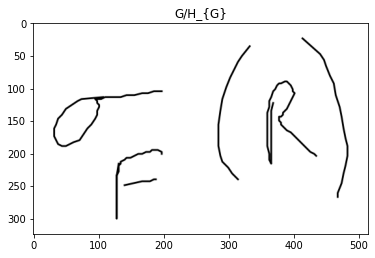

Epoch-->0 Blue Score : 0.22415965795516968
Epoch 0 Training_Loss : 1.1211426258087158 
Epoch 1 Training_Loss : 1.0976349115371704 
Epoch 2 Training_Loss : 1.0944156646728516 
Epoch 3 Training_Loss : 1.08887779712677 
Epoch 4 Training_Loss : 1.0806968212127686 
Epoch 5 Training_Loss : 1.0737025737762451 
Epoch 6 Training_Loss : 1.0712085962295532 
Epoch 7 Training_Loss : 1.0621891021728516 
Epoch 8 Training_Loss : 1.0594955682754517 
Epoch 9 Training_Loss : 1.0720800161361694 


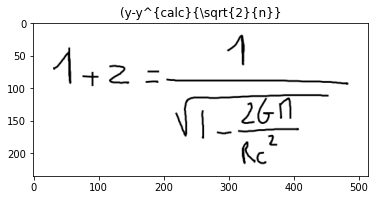

Epoch-->10 Blue Score : 0.3572486937046051
Epoch 10 Training_Loss : 1.0526210069656372 
Epoch 11 Training_Loss : 1.0455012321472168 
Epoch 12 Training_Loss : 1.0398677587509155 
Epoch 13 Training_Loss : 1.0401314496994019 
Epoch 14 Training_Loss : 1.038564920425415 
Epoch 15 Training_Loss : 1.0501317977905273 
Epoch 16 Training_Loss : 1.0636510848999023 
Epoch 17 Training_Loss : 1.0685198307037354 
Epoch 18 Training_Loss : 1.0479011535644531 
Epoch 19 Training_Loss : 1.0285038948059082 


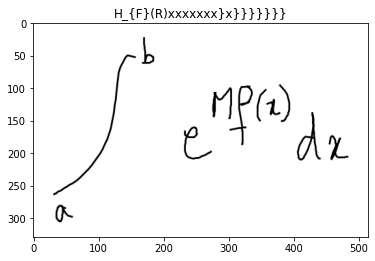

Epoch-->20 Blue Score : 0.38915807008743286
Epoch 20 Training_Loss : 1.037295937538147 
Epoch 21 Training_Loss : 1.0481128692626953 
Epoch 22 Training_Loss : 1.0375303030014038 
Epoch 23 Training_Loss : 1.0262686014175415 
Epoch 24 Training_Loss : 1.01976478099823 
Epoch 25 Training_Loss : 1.0226010084152222 
Epoch 26 Training_Loss : 1.016270399093628 
Epoch 27 Training_Loss : 1.011971354484558 
Epoch 28 Training_Loss : 1.0144511461257935 
Epoch 29 Training_Loss : 1.012339472770691 


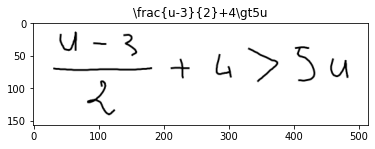

Epoch-->30 Blue Score : 0.4379107654094696
Epoch 30 Training_Loss : 1.004197359085083 
Epoch 31 Training_Loss : 1.0019053220748901 
Epoch 32 Training_Loss : 0.9985308647155762 
Epoch 33 Training_Loss : 0.9953213334083557 
Epoch 34 Training_Loss : 0.9926549792289734 
Epoch 35 Training_Loss : 0.9916790723800659 
Epoch 36 Training_Loss : 0.991083025932312 
Epoch 37 Training_Loss : 0.990165650844574 
Epoch 38 Training_Loss : 0.9881153702735901 
Epoch 39 Training_Loss : 0.9870021939277649 


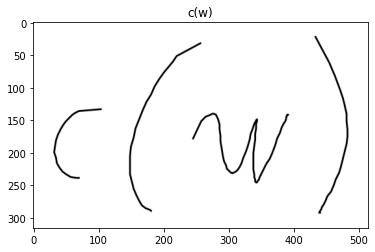

Epoch-->40 Blue Score : 0.42551088333129883
Epoch 40 Training_Loss : 0.9864705204963684 
Epoch 41 Training_Loss : 0.9859643578529358 
Epoch 42 Training_Loss : 0.9883561134338379 
Epoch 43 Training_Loss : 1.0064524412155151 
Epoch 44 Training_Loss : 1.2486612796783447 
Epoch 45 Training_Loss : 1.4224326610565186 
Epoch 46 Training_Loss : 1.6837928295135498 
Epoch 47 Training_Loss : 1.3759360313415527 
Epoch 48 Training_Loss : 1.7979307174682617 
Epoch 49 Training_Loss : 1.5196030139923096 


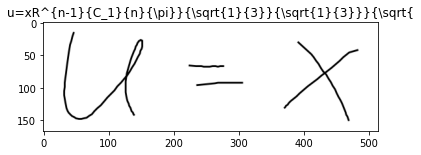

Epoch-->50 Blue Score : 0.02430076338350773
Epoch 50 Training_Loss : 1.2909661531448364 
Epoch 51 Training_Loss : 1.2224705219268799 
Epoch 52 Training_Loss : 1.208222508430481 
Epoch 53 Training_Loss : 1.39524245262146 
Epoch 54 Training_Loss : 1.3366360664367676 
Epoch 55 Training_Loss : 1.3196247816085815 
Epoch 56 Training_Loss : 1.2554322481155396 
Epoch 57 Training_Loss : 1.2521775960922241 
Epoch 58 Training_Loss : 1.336456537246704 
Epoch 59 Training_Loss : 1.337199330329895 


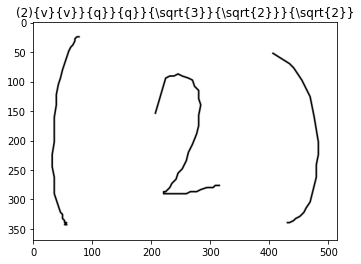

Epoch-->60 Blue Score : 0.08510722219944
Epoch 60 Training_Loss : 1.2240142822265625 
Epoch 61 Training_Loss : 1.194361686706543 
Epoch 62 Training_Loss : 1.2102051973342896 
Epoch 63 Training_Loss : 1.1362305879592896 
Epoch 64 Training_Loss : 1.1505194902420044 
Epoch 65 Training_Loss : 1.120861530303955 
Epoch 66 Training_Loss : 1.0540248155593872 
Epoch 67 Training_Loss : 1.047499418258667 
Epoch 68 Training_Loss : 1.052450180053711 
Epoch 69 Training_Loss : 1.0479179620742798 


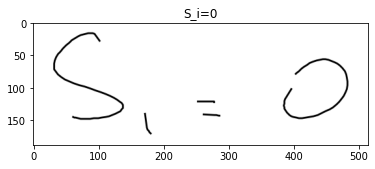

Epoch-->70 Blue Score : 0.13083550333976746
Epoch 70 Training_Loss : 1.056985855102539 
Epoch 71 Training_Loss : 1.048477292060852 
Epoch 72 Training_Loss : 1.0383946895599365 
Epoch 73 Training_Loss : 1.0239845514297485 
Epoch 74 Training_Loss : 1.0183721780776978 
Epoch 75 Training_Loss : 1.01328706741333 
Epoch 76 Training_Loss : 1.0163072347640991 
Epoch 77 Training_Loss : 1.0170432329177856 
Epoch 78 Training_Loss : 1.016632080078125 
Epoch 79 Training_Loss : 1.0122785568237305 


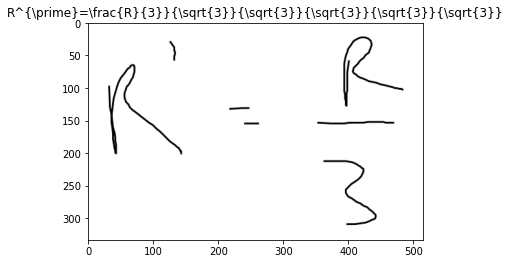

Epoch-->80 Blue Score : 0.17822307348251343
Epoch 80 Training_Loss : 1.0032167434692383 
Epoch 81 Training_Loss : 0.9973427057266235 
Epoch 82 Training_Loss : 0.9919469952583313 
Epoch 83 Training_Loss : 0.9896335005760193 
Epoch 84 Training_Loss : 0.9892609119415283 
Epoch 85 Training_Loss : 0.9885625839233398 
Epoch 86 Training_Loss : 0.9874226450920105 
Epoch 87 Training_Loss : 0.9856299161911011 
Epoch 88 Training_Loss : 0.9840469360351562 
Epoch 89 Training_Loss : 0.9828568696975708 


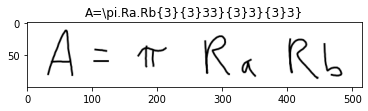

Epoch-->90 Blue Score : 0.20135332643985748
Epoch 90 Training_Loss : 0.9819647669792175 
Epoch 91 Training_Loss : 0.9811856746673584 
Epoch 92 Training_Loss : 0.9807540774345398 
Epoch 93 Training_Loss : 0.9800830483436584 
Epoch 94 Training_Loss : 0.9790811538696289 
Epoch 95 Training_Loss : 0.9781160354614258 
Epoch 96 Training_Loss : 0.9771988391876221 
Epoch 97 Training_Loss : 0.9767631888389587 
Epoch 98 Training_Loss : 0.9754697680473328 
Epoch 99 Training_Loss : 0.9749239087104797 


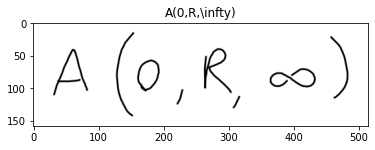

Epoch-->100 Blue Score : 0.20299606025218964
Epoch 100 Training_Loss : 0.9751863479614258 
Epoch 101 Training_Loss : 0.97357577085495 
Epoch 102 Training_Loss : 0.9741154909133911 
Epoch 103 Training_Loss : 0.974430501461029 
Epoch 104 Training_Loss : 0.9758437275886536 
Epoch 105 Training_Loss : 0.97470623254776 
Epoch 106 Training_Loss : 0.9753559231758118 
Epoch 107 Training_Loss : 0.9727981686592102 
Epoch 108 Training_Loss : 0.9719817042350769 
Epoch 109 Training_Loss : 0.9724938273429871 


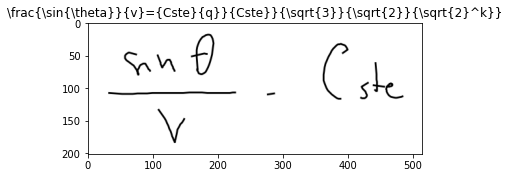

Epoch-->110 Blue Score : 0.2199225127696991
Epoch 110 Training_Loss : 0.9735040068626404 
Epoch 111 Training_Loss : 0.9745656251907349 
Epoch 112 Training_Loss : 0.9764065742492676 
Epoch 113 Training_Loss : 0.9723379611968994 
Epoch 114 Training_Loss : 0.9727124571800232 
Epoch 115 Training_Loss : 0.9699605107307434 
Epoch 116 Training_Loss : 0.9685361385345459 
Epoch 117 Training_Loss : 0.9671950936317444 
Epoch 118 Training_Loss : 0.9664714336395264 
Epoch 119 Training_Loss : 0.9662944078445435 


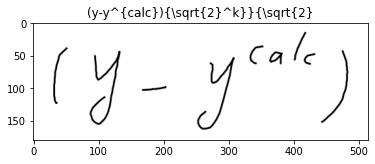

Epoch-->120 Blue Score : 0.21953479945659637
Epoch 120 Training_Loss : 0.9661909937858582 
Epoch 121 Training_Loss : 0.9660859704017639 
Epoch 122 Training_Loss : 0.965616762638092 
Epoch 123 Training_Loss : 0.9650506377220154 
Epoch 124 Training_Loss : 0.9643601775169373 
Epoch 125 Training_Loss : 0.9639948606491089 
Epoch 126 Training_Loss : 0.9638505578041077 
Epoch 127 Training_Loss : 0.9636497497558594 
Epoch 128 Training_Loss : 0.9632804989814758 
Epoch 129 Training_Loss : 0.9630280137062073 


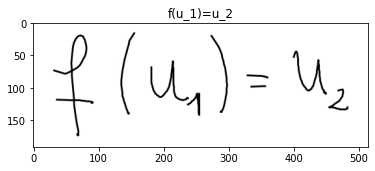

Epoch-->130 Blue Score : 0.22930610179901123
Epoch 130 Training_Loss : 0.9628270268440247 
Epoch 131 Training_Loss : 0.9626697897911072 
Epoch 132 Training_Loss : 0.9627655148506165 
Epoch 133 Training_Loss : 0.9626555442810059 
Epoch 134 Training_Loss : 0.9626818299293518 
Epoch 135 Training_Loss : 0.9626074433326721 
Epoch 136 Training_Loss : 0.9622130393981934 
Epoch 137 Training_Loss : 0.9710356593132019 
Epoch 138 Training_Loss : 0.96826171875 
Epoch 139 Training_Loss : 0.9650591611862183 


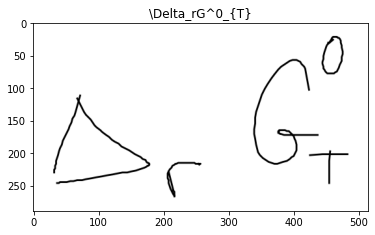

Epoch-->140 Blue Score : 0.19385726749897003
Epoch 140 Training_Loss : 0.970154881477356 
Epoch 141 Training_Loss : 0.9791721105575562 
Epoch 142 Training_Loss : 1.24971604347229 
Epoch 143 Training_Loss : 1.5071477890014648 
Epoch 144 Training_Loss : 1.567433476448059 
Epoch 145 Training_Loss : 1.1288576126098633 
Epoch 146 Training_Loss : 1.1056630611419678 
Epoch 147 Training_Loss : 1.0672879219055176 
Epoch 148 Training_Loss : 1.0339252948760986 
Epoch 149 Training_Loss : 1.0335593223571777 


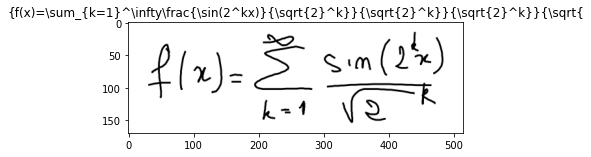

Epoch-->150 Blue Score : 0.1479121297597885
Epoch 150 Training_Loss : 1.091431975364685 
Epoch 151 Training_Loss : 1.0201886892318726 
Epoch 152 Training_Loss : 1.0289874076843262 
Epoch 153 Training_Loss : 1.0201479196548462 
Epoch 154 Training_Loss : 1.004454493522644 
Epoch 155 Training_Loss : 1.0062060356140137 
Epoch 156 Training_Loss : 0.9884224534034729 
Epoch 157 Training_Loss : 0.9857615232467651 
Epoch 158 Training_Loss : 0.9826290011405945 
Epoch 159 Training_Loss : 0.9803709387779236 


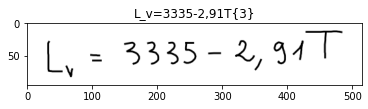

Epoch-->160 Blue Score : 0.16400393843650818
Epoch 160 Training_Loss : 0.9742094278335571 
Epoch 161 Training_Loss : 0.9715726375579834 
Epoch 162 Training_Loss : 0.9709739089012146 
Epoch 163 Training_Loss : 0.9706220626831055 
Epoch 164 Training_Loss : 0.9684973359107971 
Epoch 165 Training_Loss : 0.9768950939178467 
Epoch 166 Training_Loss : 0.9746180176734924 
Epoch 167 Training_Loss : 0.9782504439353943 
Epoch 168 Training_Loss : 0.9845036268234253 
Epoch 169 Training_Loss : 0.9728431701660156 


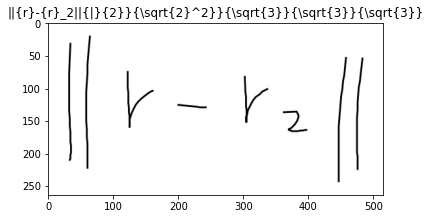

Epoch-->170 Blue Score : 0.12552478909492493
Epoch 170 Training_Loss : 0.972830593585968 
Epoch 171 Training_Loss : 0.9795836806297302 
Epoch 172 Training_Loss : 0.9742209911346436 
Epoch 173 Training_Loss : 0.973946213722229 
Epoch 174 Training_Loss : 0.9721649289131165 
Epoch 175 Training_Loss : 0.9691095352172852 
Epoch 176 Training_Loss : 0.968180239200592 
Epoch 177 Training_Loss : 0.9942387938499451 
Epoch 178 Training_Loss : 0.9661359190940857 
Epoch 179 Training_Loss : 0.9666298031806946 


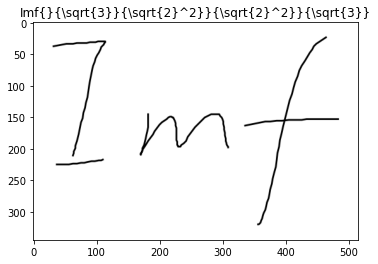

Epoch-->180 Blue Score : 0.20910654962062836
Epoch 180 Training_Loss : 0.9707304835319519 
Epoch 181 Training_Loss : 0.9685629606246948 
Epoch 182 Training_Loss : 1.0133572816848755 
Epoch 183 Training_Loss : 0.9686809778213501 
Epoch 184 Training_Loss : 0.9670044183731079 
Epoch 185 Training_Loss : 0.9644414782524109 
Epoch 186 Training_Loss : 0.9652238488197327 
Epoch 187 Training_Loss : 0.9641819596290588 
Epoch 188 Training_Loss : 0.963756799697876 
Epoch 189 Training_Loss : 1.027254343032837 


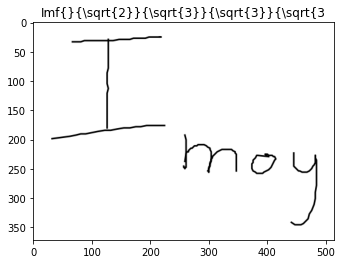

Epoch-->190 Blue Score : 0.23647333681583405
Epoch 190 Training_Loss : 1.6642457246780396 
Epoch 191 Training_Loss : 1.2570099830627441 
Epoch 192 Training_Loss : 0.9877733588218689 
Epoch 193 Training_Loss : 0.9861776232719421 
Epoch 194 Training_Loss : 0.996101438999176 
Epoch 195 Training_Loss : 1.0089504718780518 
Epoch 196 Training_Loss : 0.9868524074554443 
Epoch 197 Training_Loss : 0.9844363331794739 
Epoch 198 Training_Loss : 0.9797307252883911 
Epoch 199 Training_Loss : 0.973127543926239 


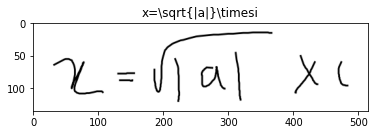

Epoch-->200 Blue Score : 0.2550341486930847
Epoch 200 Training_Loss : 0.9682462811470032 
Epoch 201 Training_Loss : 0.9641221165657043 
Epoch 202 Training_Loss : 0.9620074033737183 
Epoch 203 Training_Loss : 0.9616655111312866 
Epoch 204 Training_Loss : 0.961715817451477 
Epoch 205 Training_Loss : 0.9618979096412659 
Epoch 206 Training_Loss : 0.9619196057319641 
Epoch 207 Training_Loss : 0.9619978666305542 
Epoch 208 Training_Loss : 0.9621583819389343 
Epoch 209 Training_Loss : 0.9617446064949036 


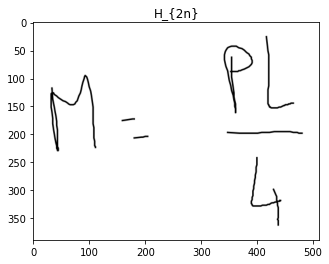

Epoch-->210 Blue Score : 0.25450074672698975
Epoch 210 Training_Loss : 0.9616215229034424 
Epoch 211 Training_Loss : 0.9612687826156616 
Epoch 212 Training_Loss : 0.9609223008155823 
Epoch 213 Training_Loss : 0.9606578350067139 
Epoch 214 Training_Loss : 0.9604855179786682 
Epoch 215 Training_Loss : 0.9602525234222412 
Epoch 216 Training_Loss : 0.9600934386253357 
Epoch 217 Training_Loss : 0.9599764347076416 
Epoch 218 Training_Loss : 0.9599133729934692 
Epoch 219 Training_Loss : 0.959466278553009 


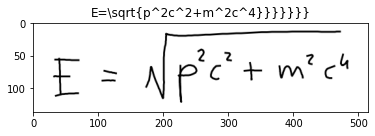

Epoch-->220 Blue Score : 0.2702683210372925
Epoch 220 Training_Loss : 0.95923912525177 
Epoch 221 Training_Loss : 0.9591103196144104 
Epoch 222 Training_Loss : 0.959073543548584 
Epoch 223 Training_Loss : 0.9592903852462769 
Epoch 224 Training_Loss : 0.9592601656913757 
Epoch 225 Training_Loss : 0.9591071605682373 
Epoch 226 Training_Loss : 0.9588454961776733 
Epoch 227 Training_Loss : 0.9586264491081238 
Epoch 228 Training_Loss : 0.958522379398346 
Epoch 229 Training_Loss : 0.9584685564041138 


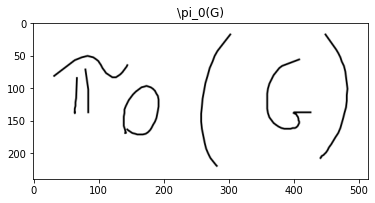

Epoch-->230 Blue Score : 0.25124314427375793
Epoch 230 Training_Loss : 0.9584397673606873 
Epoch 231 Training_Loss : 0.9584928750991821 
Epoch 232 Training_Loss : 0.9588010311126709 
Epoch 233 Training_Loss : 0.9589145183563232 
Epoch 234 Training_Loss : 0.9587665796279907 
Epoch 235 Training_Loss : 0.9585475921630859 
Epoch 236 Training_Loss : 0.9583235383033752 
Epoch 237 Training_Loss : 0.9581329822540283 
Epoch 238 Training_Loss : 0.9579675793647766 
Epoch 239 Training_Loss : 0.9578191041946411 


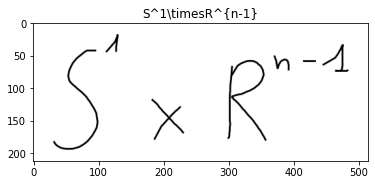

Epoch-->240 Blue Score : 0.24747639894485474
Epoch 240 Training_Loss : 0.957731306552887 
Epoch 241 Training_Loss : 0.9576689600944519 
Epoch 242 Training_Loss : 0.9575604200363159 
Epoch 243 Training_Loss : 0.957334578037262 
Epoch 244 Training_Loss : 0.9567919969558716 
Epoch 245 Training_Loss : 0.9561619162559509 
Epoch 246 Training_Loss : 0.9558757543563843 
Epoch 247 Training_Loss : 0.9557824730873108 
Epoch 248 Training_Loss : 0.9557373523712158 
Epoch 249 Training_Loss : 0.9557082056999207 


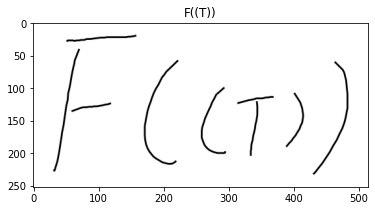

Epoch-->250 Blue Score : 0.24316546320915222
Epoch 250 Training_Loss : 0.9556868076324463 
Epoch 251 Training_Loss : 0.9558913707733154 
Epoch 252 Training_Loss : 0.9559978246688843 
Epoch 253 Training_Loss : 0.9556146860122681 
Epoch 254 Training_Loss : 0.9554920196533203 
Epoch 255 Training_Loss : 0.9554793238639832 
Epoch 256 Training_Loss : 0.9554771780967712 
Epoch 257 Training_Loss : 0.955608069896698 
Epoch 258 Training_Loss : 0.9555999636650085 
Epoch 259 Training_Loss : 0.955552875995636 


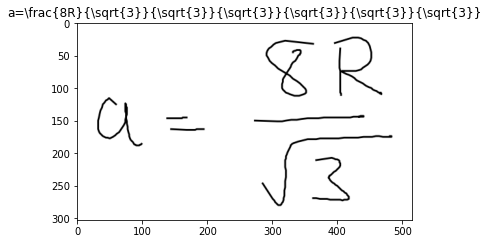

Epoch-->260 Blue Score : 0.22485679388046265
Epoch 260 Training_Loss : 0.9555931091308594 
Epoch 261 Training_Loss : 0.9555258750915527 
Epoch 262 Training_Loss : 0.9554381370544434 
Epoch 263 Training_Loss : 0.9554096460342407 
Epoch 264 Training_Loss : 0.9553901553153992 
Epoch 265 Training_Loss : 0.955315351486206 
Epoch 266 Training_Loss : 0.9552537798881531 
Epoch 267 Training_Loss : 0.9551995396614075 
Epoch 268 Training_Loss : 0.9551464319229126 
Epoch 269 Training_Loss : 0.9550938010215759 


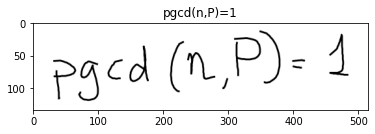

Epoch-->270 Blue Score : 0.2257022261619568
Epoch 270 Training_Loss : 0.9550420641899109 
Epoch 271 Training_Loss : 0.9549877047538757 
Epoch 272 Training_Loss : 0.9549272060394287 
Epoch 273 Training_Loss : 0.9548620581626892 
Epoch 274 Training_Loss : 0.9555233716964722 
Epoch 275 Training_Loss : 0.9554678797721863 
Epoch 276 Training_Loss : 0.9546695351600647 
Epoch 277 Training_Loss : 0.9546136856079102 
Epoch 278 Training_Loss : 0.9545605778694153 
Epoch 279 Training_Loss : 0.9545129537582397 


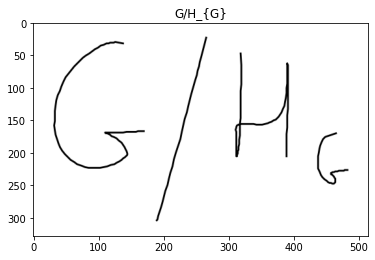

Epoch-->280 Blue Score : 0.22689655423164368
Epoch 280 Training_Loss : 0.9544728994369507 
Epoch 281 Training_Loss : 0.9544416069984436 
Epoch 282 Training_Loss : 0.9544207453727722 
Epoch 283 Training_Loss : 0.9544060826301575 
Epoch 284 Training_Loss : 0.9544209837913513 
Epoch 285 Training_Loss : 0.9543877840042114 
Epoch 286 Training_Loss : 0.9543679356575012 
Epoch 287 Training_Loss : 0.9543493986129761 
Epoch 288 Training_Loss : 0.9543328285217285 
Epoch 289 Training_Loss : 0.9543202519416809 


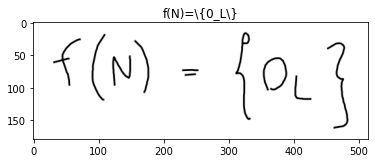

Epoch-->290 Blue Score : 0.22502535581588745
Epoch 290 Training_Loss : 0.9543155431747437 
Epoch 291 Training_Loss : 0.9543179273605347 
Epoch 292 Training_Loss : 0.9543225765228271 
Epoch 293 Training_Loss : 0.954323410987854 
Epoch 294 Training_Loss : 0.9543169140815735 
Epoch 295 Training_Loss : 0.9543049335479736 
Epoch 296 Training_Loss : 0.954292893409729 
Epoch 297 Training_Loss : 0.9542791843414307 
Epoch 298 Training_Loss : 0.9542668461799622 
Epoch 299 Training_Loss : 0.9542564749717712 


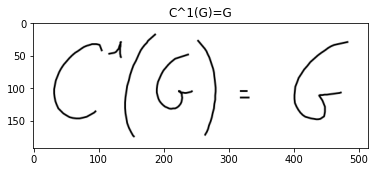

Epoch-->300 Blue Score : 0.2255326211452484
Epoch 300 Training_Loss : 0.9542462229728699 
Epoch 301 Training_Loss : 0.9542344808578491 
Epoch 302 Training_Loss : 0.9542198181152344 
Epoch 303 Training_Loss : 0.9542931318283081 
Epoch 304 Training_Loss : 0.9542720913887024 
Epoch 305 Training_Loss : 0.9542502164840698 
Epoch 306 Training_Loss : 0.9542290568351746 
Epoch 307 Training_Loss : 0.9542095065116882 
Epoch 308 Training_Loss : 0.954190731048584 
Epoch 309 Training_Loss : 0.9541723132133484 


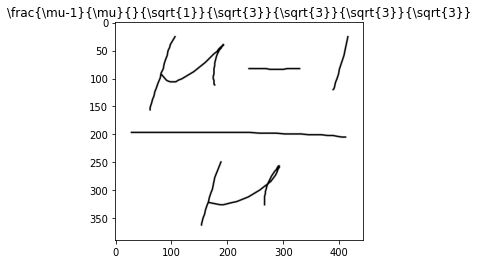

Epoch-->310 Blue Score : 0.22301892936229706
Epoch 310 Training_Loss : 0.9541536569595337 
Epoch 311 Training_Loss : 0.9541342854499817 
Epoch 312 Training_Loss : 0.9541140198707581 
Epoch 313 Training_Loss : 0.9540926218032837 
Epoch 314 Training_Loss : 0.9540725946426392 
Epoch 315 Training_Loss : 0.954058825969696 
Epoch 316 Training_Loss : 0.9540481567382812 
Epoch 317 Training_Loss : 0.9539624452590942 
Epoch 318 Training_Loss : 0.9539417028427124 
Epoch 319 Training_Loss : 0.9539211392402649 


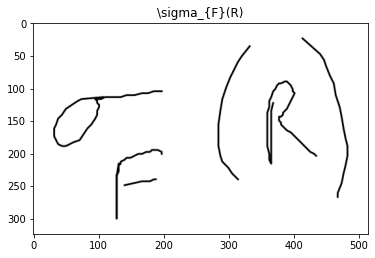

Epoch-->320 Blue Score : 0.22326777875423431
Epoch 320 Training_Loss : 0.9538993835449219 
Epoch 321 Training_Loss : 0.9538716673851013 
Epoch 322 Training_Loss : 0.9538416862487793 
Epoch 323 Training_Loss : 0.953811526298523 
Epoch 324 Training_Loss : 0.9537767171859741 
Epoch 325 Training_Loss : 0.9537321329116821 
Epoch 326 Training_Loss : 0.9536973834037781 
Epoch 327 Training_Loss : 0.9536969661712646 
Epoch 328 Training_Loss : 0.9536908864974976 
Epoch 329 Training_Loss : 0.953675389289856 


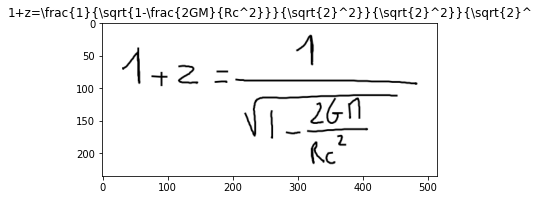

Epoch-->330 Blue Score : 0.22326777875423431
Epoch 330 Training_Loss : 0.9536548256874084 
Epoch 331 Training_Loss : 0.9536405205726624 
Epoch 332 Training_Loss : 0.9536338448524475 
Epoch 333 Training_Loss : 0.9536237120628357 
Epoch 334 Training_Loss : 0.9536121487617493 
Epoch 335 Training_Loss : 0.9536041021347046 
Epoch 336 Training_Loss : 0.9535977840423584 
Epoch 337 Training_Loss : 0.953590989112854 
Epoch 338 Training_Loss : 0.9535849690437317 
Epoch 339 Training_Loss : 0.953577995300293 


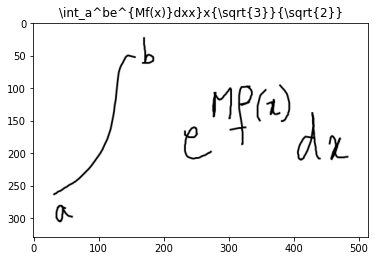

Epoch-->340 Blue Score : 0.22277064621448517
Epoch 340 Training_Loss : 0.9535688757896423 
Epoch 341 Training_Loss : 0.9535586833953857 
Epoch 342 Training_Loss : 0.9535470008850098 
Epoch 343 Training_Loss : 0.9535354375839233 
Epoch 344 Training_Loss : 0.9535243511199951 
Epoch 345 Training_Loss : 0.9535136222839355 
Epoch 346 Training_Loss : 0.953502893447876 
Epoch 347 Training_Loss : 0.9534918665885925 
Epoch 348 Training_Loss : 0.9534807801246643 
Epoch 349 Training_Loss : 0.9534703493118286 


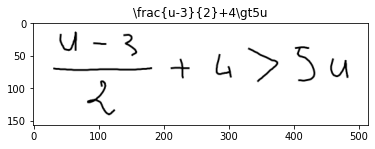

Epoch-->350 Blue Score : 0.22202907502651215
Epoch 350 Training_Loss : 0.9534614682197571 
Epoch 351 Training_Loss : 0.9534520506858826 
Epoch 352 Training_Loss : 0.9534431099891663 
Epoch 353 Training_Loss : 0.9534356594085693 
Epoch 354 Training_Loss : 0.9534279108047485 
Epoch 355 Training_Loss : 0.9534174799919128 
Epoch 356 Training_Loss : 0.953404426574707 
Epoch 357 Training_Loss : 0.9533917903900146 
Epoch 358 Training_Loss : 0.9533798098564148 
Epoch 359 Training_Loss : 0.953366756439209 


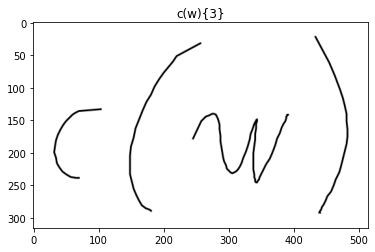

Epoch-->360 Blue Score : 0.2222757339477539
Epoch 360 Training_Loss : 0.9533520340919495 
Epoch 361 Training_Loss : 0.9533374309539795 
Epoch 362 Training_Loss : 0.9533234238624573 
Epoch 363 Training_Loss : 0.9533094167709351 
Epoch 364 Training_Loss : 0.9532955288887024 
Epoch 365 Training_Loss : 0.9532821774482727 
Epoch 366 Training_Loss : 0.9532697200775146 
Epoch 367 Training_Loss : 0.9532578587532043 
Epoch 368 Training_Loss : 0.9532462954521179 
Epoch 369 Training_Loss : 0.9532356262207031 


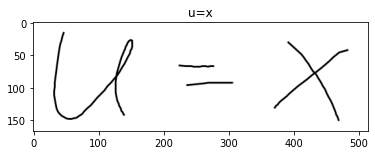

Epoch-->370 Blue Score : 0.2222757339477539
Epoch 370 Training_Loss : 0.953225314617157 
Epoch 371 Training_Loss : 0.9532151818275452 
Epoch 372 Training_Loss : 0.9532049298286438 
Epoch 373 Training_Loss : 0.9531947374343872 
Epoch 374 Training_Loss : 0.9531846046447754 
Epoch 375 Training_Loss : 0.9531746506690979 
Epoch 376 Training_Loss : 0.9531649351119995 
Epoch 377 Training_Loss : 0.953155517578125 
Epoch 378 Training_Loss : 0.9531461596488953 
Epoch 379 Training_Loss : 0.9531370997428894 


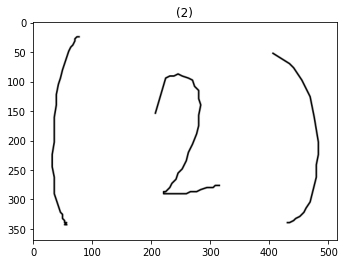

Epoch-->380 Blue Score : 0.22047965228557587
Epoch 380 Training_Loss : 0.9531276226043701 
Epoch 381 Training_Loss : 0.9531175494194031 
Epoch 382 Training_Loss : 0.9531064033508301 
Epoch 383 Training_Loss : 0.9530935883522034 
Epoch 384 Training_Loss : 0.9530795812606812 
Epoch 385 Training_Loss : 0.9530666470527649 
Epoch 386 Training_Loss : 0.9530562162399292 
Epoch 387 Training_Loss : 0.9530476927757263 
Epoch 388 Training_Loss : 0.9530394077301025 
Epoch 389 Training_Loss : 0.9530302286148071 


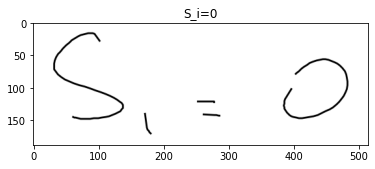

Epoch-->390 Blue Score : 0.22153742611408234
Epoch 390 Training_Loss : 0.9530186057090759 
Epoch 391 Training_Loss : 0.9530046582221985 
Epoch 392 Training_Loss : 0.9529920816421509 
Epoch 393 Training_Loss : 0.9529825448989868 
Epoch 394 Training_Loss : 0.9529752135276794 
Epoch 395 Training_Loss : 0.9529686570167542 
Epoch 396 Training_Loss : 0.952962338924408 
Epoch 397 Training_Loss : 0.9529571533203125 
Epoch 398 Training_Loss : 0.9529523253440857 
Epoch 399 Training_Loss : 0.9529467821121216 


In [100]:
M = len(overfit_batch)

alpha_c = 1
#overfitting to  a batch 
for i in range(400):
    # print(overfit_batch["images"].shape)
    # print(overfit_batch["encoded_latexes"].shape)
    # print(overfit_batch["lengths"].shape)
    
  Baseline_model_optimizer.zero_grad()
  # batch_loss_value = 0
  for index , k in enumerate(overfit_batch):
    images = k["image"].to(device)
    latexes = k["encoded_latex"].to(device)

    scores  , alphas  = Baseline_model(images.float(),latexes)
    
    
    targets = latexes[:,1:]
    loss = criterion(scores.view(-1,121), targets.reshape(-1))
    loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()
    
    loss.backward()
    # batch_loss_value += loss.cpu().numpy()[0]

    if index == 32 :

        Baseline_model_optimizer.step()
        Baseline_model_optimizer.zero_grad()

  Baseline_model_optimizer.step()


    
  # torch.nn.utils.clip_grad_norm_(Baseline_model.parameters(), 5)

  # batch_loss_value = batch_lossvalue/M

  if (i % 10) == 0:            
            
            #generate the caption
            Baseline_model.eval()
            with torch.no_grad():
                im = overfit_batch[i%64]["image"].to(device)
                decoded,alphas = Baseline_model.generate_caption(im , device = device)
                show_image(im.cpu().byte().squeeze(0),title=decoded)
                predicted_lats_val ,val_latexes_truth = [] ,[]
          
          
          
                for x in (overfit_batch):
                  image = x["image"].to(device)
                  latex = x["encoded_latex"]
                  decoded_lat , _ = Baseline_model.generate_caption(image , max_len=100)
                  predicted_lats_val.append(decoded_lat)
                  truth_val = [reverse_vocab[tok] for tok in latex.squeeze(0).tolist() if tok not in {116,117,118}]
                  val_latexes_truth.append([truth_val])

                b = bleu_score(predicted_lats_val,val_latexes_truth )
                print(f"Epoch-->{i} Blue Score : {b}")
  
            

  print(f"Epoch {i} Training_Loss : {loss} ")

